In [1]:
!pip install efficientnet-pytorch -qqq

In [2]:
from fastai.vision.all import *


import albumentations # Data Augmentation
from efficientnet_pytorch import EfficientNet # The Model
import os
import numpy as np
import pandas as pd 
from PIL import Image

from fastai import *
from fastai.vision.all import *
from fastai.callback import *

In [3]:
path = Path("../input")
data_path = path/'plant-pathology-2021-fgvc8'

In [4]:
df = pd.read_csv(data_path/'train.csv', low_memory=False)
df

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


In [5]:
df.labels.value_counts(dropna=False), df.labels.value_counts(dropna=False).unique()

(scab                               4826
 healthy                            4624
 frog_eye_leaf_spot                 3181
 rust                               1860
 complex                            1602
 powdery_mildew                     1184
 scab frog_eye_leaf_spot             686
 scab frog_eye_leaf_spot complex     200
 frog_eye_leaf_spot complex          165
 rust frog_eye_leaf_spot             120
 rust complex                         97
 powdery_mildew complex               87
 Name: labels, dtype: int64,
 array([4826, 4624, 3181, 1860, 1602, 1184,  686,  200,  165,  120,   97,
          87]))

In [6]:
(data_path/"train_images").ls()

(#18632) [Path('../input/plant-pathology-2021-fgvc8/train_images/a8d54d0d96517ab3.jpg'),Path('../input/plant-pathology-2021-fgvc8/train_images/ac6902fd1f0f3ce0.jpg'),Path('../input/plant-pathology-2021-fgvc8/train_images/d4b7ea94e1c509e2.jpg'),Path('../input/plant-pathology-2021-fgvc8/train_images/c780633f9d9d2970.jpg'),Path('../input/plant-pathology-2021-fgvc8/train_images/a506c47f0f2d3d61.jpg'),Path('../input/plant-pathology-2021-fgvc8/train_images/d4d8689596df6b80.jpg'),Path('../input/plant-pathology-2021-fgvc8/train_images/edd8cfc45e503252.jpg'),Path('../input/plant-pathology-2021-fgvc8/train_images/9ab326c1951acb7a.jpg'),Path('../input/plant-pathology-2021-fgvc8/train_images/f728e036d729a0ad.jpg'),Path('../input/plant-pathology-2021-fgvc8/train_images/fce318c6518fd20e.jpg')...]

In [7]:
def get_x(r):  return data_path/"train_images"/r["image"]
def get_y(r):  return r["labels"]
f1_score_multi = F1Score(average="weighted")

### Follow fastai's tutorial on [custom transformation](https://docs.fast.ai/tutorial.albumentations.html).

We added in a split_idx, which is what determines what transforms are run on the validation set and the training set (0 for train, 1 for validation, None for both). We wanted special different behaviors applied to both the training and validation sets, so we set our split_idx to be None, which allows for us to say when we're setting our split_idx.

We also inherit from RandTransform, which allows for us to set that split_idx in our before_call.

Finally we check to see what the current split_idx is. If it's 0, run the trainining augmentation, otherwise run the validation augmentation.

Along with this we set an order to 2. What this entails is if we have any fastai transforms that perform a resize operation, those are done first before our new transform. This let's us know exactly when our transform is going to be applied, and how we can work with it!

In [8]:
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

https://albumentations.ai/docs/api_reference/augmentations/transforms/

In [9]:
def get_train_aug(): return albumentations.Compose([
            albumentations.RandomResizedCrop(224,224),
            albumentations.Transpose(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
])

def get_valid_aug(): return albumentations.Compose([
    albumentations.CenterCrop(224,224, p=1.),
    albumentations.Resize(224,224)
], p=1.)

In [10]:
item_tfms = [Resize(256), AlbumentationsTransform(get_train_aug(), get_valid_aug())]

In [11]:
plants = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_x= get_x, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y= get_y,
                 item_tfms=item_tfms,
                 batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [12]:
dls = plants.dataloaders(df,batch_size=32)

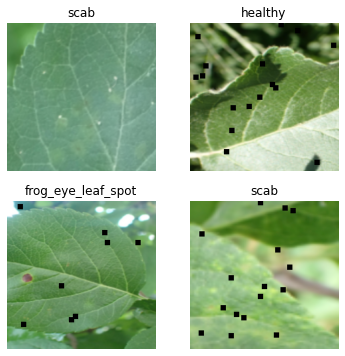

In [13]:
dls.show_batch(max_n=4)

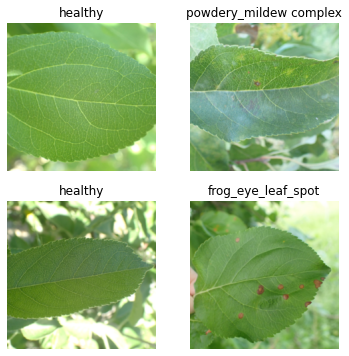

In [14]:
dls.valid.show_batch(max_n=4)

https://github.com/lukemelas/EfficientNet-PyTorch

### Try version 3

In [15]:
class LeafModel(Module):
    def __init__(self, num_classes):

        self.effnet = EfficientNet.from_pretrained("efficientnet-b3")
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(1536, num_classes)

    def forward(self, image):
        batch_size, _, _, _ = image.shape

        x = self.effnet.extract_features(image)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1)
        outputs = self.out(self.dropout(x))
        return outputs

In [16]:
net = LeafModel(dls.c)

Loaded pretrained weights for efficientnet-b7


In [17]:
learn = Learner(dls, net, loss_func=CrossEntropyLossFlat(),
               metrics=[accuracy,f1_score_multi]).to_fp16()

In [18]:
learn.fine_tune(8,cbs=[EarlyStoppingCallback(patience=2),
                      SaveModelCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time


RuntimeError: mat1 dim 1 must match mat2 dim 0

In [ ]:
learn.export('efficientnetb3_baseline.pkl')